In [1]:
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff
import warnings
warnings.filterwarnings('ignore')

In [2]:
coldf=pd.read_csv('colData_GSE137140.csv',delimiter=';')
rowdf=pd.read_csv('rowData_GSE137140.csv',delimiter=';')
assaydf=pd.read_csv('assay_GSE137140.csv',delimiter=';')
display(coldf.head())
display(rowdf.head())
display(assaydf.head())

,Unnamed: 0,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,...,contact_address,contact_city,contact_zip.postal_code,contact_country,supplementary_file,data_row_count,age.ch1,disease.state.ch1,Sex.ch1,tissue.ch1
0,GSM4067570,BC0921,GSM4067570,Public on Mar 30 2020,Sep 09 2019,Mar 30 2020,RNA,1,Serum,Homo sapiens,...,kamakurashi,Kanagawa,248-8555,Japan,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4067...,2565,51.0,Non-cancer control,Female,serum
1,GSM4067571,BC0962,GSM4067571,Public on Mar 30 2020,Sep 09 2019,Mar 30 2020,RNA,1,Serum,Homo sapiens,...,kamakurashi,Kanagawa,248-8555,Japan,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4067...,2565,46.0,Non-cancer control,Female,serum
2,GSM4067572,BC0963,GSM4067572,Public on Mar 30 2020,Sep 09 2019,Mar 30 2020,RNA,1,Serum,Homo sapiens,...,kamakurashi,Kanagawa,248-8555,Japan,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4067...,2565,67.0,Non-cancer control,Female,serum
3,GSM4067573,BC0973,GSM4067573,Public on Mar 30 2020,Sep 09 2019,Mar 30 2020,RNA,1,Serum,Homo sapiens,...,kamakurashi,Kanagawa,248-8555,Japan,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4067...,2565,56.0,Non-cancer control,Female,serum
4,GSM4067574,BC0977,GSM4067574,Public on Mar 30 2020,Sep 09 2019,Mar 30 2020,RNA,1,Serum,Homo sapiens,...,kamakurashi,Kanagawa,248-8555,Japan,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4067...,2565,53.0,Non-cancer control,Female,serum


,Unnamed: 0,ID,miRNA,miRNA_ID_LIST
0,MIMAT0000062,MIMAT0000062,MIMAT0000062,hsa-let-7a-5p
1,MIMAT0000063,MIMAT0000063,MIMAT0000063,hsa-let-7b-5p
2,MIMAT0000064,MIMAT0000064,MIMAT0000064,hsa-let-7c-5p
3,MIMAT0000065,MIMAT0000065,MIMAT0000065,hsa-let-7d-5p
4,MIMAT0000066,MIMAT0000066,MIMAT0000066,hsa-let-7e-5p


,Unnamed: 0,GSM4067570,GSM4067571,GSM4067572,GSM4067573,GSM4067574,GSM4067575,GSM4067576,GSM4067577,GSM4067578,...,GSM4071484,GSM4071485,GSM4071486,GSM4071487,GSM4071488,GSM4071489,GSM4071490,GSM4071491,GSM4071492,GSM4071493
0,MIMAT0000062,"4,393091827","3,817743615","3,779668162","5,537472886","5,953740715","1,682941934","6,486690768","2,469667281","5,438338613",...,"-1,105000527","-0,744527358","4,703615175","-0,504938474","-0,447819666","-1,041623878","-1,107796005","-1,478146999","-0,660181295","-1,511058503"
1,MIMAT0000063,"6,306405454","-1,240935745","3,997012588","1,593297553","3,07389018","5,585973454","0,581152049","4,629925707","6,008346739",...,"-1,105000527","4,553650651","3,286193596","-0,504938474","-0,447819666","-1,041623878","-1,107796005","-1,478146999","4,04421089","-1,511058503"
2,MIMAT0000064,"5,736185613","3,740098159","0,503678265","3,843516133","0,853141306","4,333699602","4,175398812","-1,104550309","4,556129323",...,"-1,105000527","-0,744527358","3,121643619","-0,504938474","-0,447819666","-1,041623878","-1,107796005","-1,478146999","3,854959542","-1,511058503"
3,MIMAT0000065,"3,923084616","2,193073464","3,724792436","5,464835741","4,977866734","1,682941934","5,744840096","4,776691383","5,155604619",...,"-1,105000527","-0,744527358","-0,607801475","-0,504938474","-0,447819666","-1,041623878","-1,107796005","-1,478146999","-0,660181295","-1,511058503"
4,MIMAT0000066,"4,903123022","2,147514427","1,606391388","0,530398736","0,853141306","1,682941934","0,581152049","4,250007579","4,218558256",...,"-1,105000527","-0,744527358","1,804272753","-0,504938474","-0,447819666","-1,041623878","-1,107796005","-1,478146999","3,685818088","-1,511058503"


In [3]:
assaydf=assaydf.T
assaydf

,0,1,2,3,4,5,6,7,8,9,...,2555,2556,2557,2558,2559,2560,2561,2562,2563,2564
Unnamed: 0,MIMAT0000062,MIMAT0000063,MIMAT0000064,MIMAT0000065,MIMAT0000066,MIMAT0000067,MIMAT0000068,MIMAT0000069,MIMAT0000070,MIMAT0000071,...,MIMAT0031893,MIMAT0032026,MIMAT0032029,MIMAT0032110,"MIMAT0032114, MIMAT0032115",MIMAT0032116,MIMAT0033692,MIMAT0035542,MIMAT0035703,MIMAT0035704
GSM4067570,"4,393091827","6,306405454","5,736185613","3,923084616","4,903123022","-0,152745195","-0,152745195","-0,152745195","3,958536842","-0,152745195",...,"-0,152745195","-0,152745195","5,312395508","-0,152745195","-0,152745195","7,23987811","3,096797739","-0,152745195","-0,152745195","0,252978563"
GSM4067571,"3,817743615","-1,240935745","3,740098159","2,193073464","2,147514427","3,169063484","3,485990359","3,674214714","5,033755709","4,379048292",...,"-1,240935745","1,314120014","6,919165706","-1,240935745","-1,240935745","6,827426061","4,35825413","2,766291307","-1,240935745","-1,240935745"
GSM4067572,"3,779668162","3,997012588","0,503678265","3,724792436","1,606391388","3,2211602","2,860849652","4,332943347","4,093646598","3,982986494",...,"1,530600043","-1,353647319","6,632532105","-1,531526851","-1,531526851","5,173704913","4,844176936","1,14672538","-1,531526851","-1,531526851"
GSM4067573,"5,537472886","1,593297553","3,843516133","5,464835741","0,530398736","2,489050276","3,275916834","0,530398736","5,951552172","2,069957103",...,"5,404108354","0,530398736","7,903955558","4,832157199","0,530398736","6,444462463","4,290577626","0,530398736","4,570456073","4,11303482"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM4071489,"-1,041623878","-1,041623878","-1,041623878","-1,041623878","-1,041623878","-1,041623878","-1,041623878","-1,041623878","-1,041623878","-1,041623878",...,"-1,041623878","-1,041623878","5,765011492","-1,041623878","-1,041623878","5,104660957","-1,041623878","-1,041623878","-1,041623878","-1,041623878"
GSM4071490,"-1,107796005","-1,107796005","-1,107796005","-1,107796005","-1,107796005","-1,107796005","-1,107796005","-1,107796005","-1,107796005","-1,107796005",...,"-1,107796005","-1,107796005","4,555224009","-1,107796005","-1,107796005","4,820332151","5,76615654","-1,107796005","-1,107796005","-1,107796005"
GSM4071491,"-1,478146999","-1,478146999","-1,478146999","-1,478146999","-1,478146999","-1,478146999","-1,478146999","-1,478146999","-1,478146999","-1,478146999",...,"-1,478146999","-1,478146999","7,017008951","-1,478146999","-1,478146999","4,67650152","5,347158646","2,964856525","-1,478146999","-1,200794233"
GSM4071492,"-0,660181295","4,04421089","3,854959542","-0,660181295","3,685818088","4,177810793","3,740344908","4,359406246","1,737257069","-0,660181295",...,"4,422161867","-0,660181295","6,54663468","-0,660181295","-0,660181295","6,993437317","5,845910251","5,59298428","-0,660181295","-0,660181295"


In [4]:
assaydf.columns=assaydf.iloc[0,:]
assaydf=assaydf[1:]
assaydf

Unnamed: 0,MIMAT0000062,MIMAT0000063,MIMAT0000064,MIMAT0000065,MIMAT0000066,MIMAT0000067,MIMAT0000068,MIMAT0000069,MIMAT0000070,MIMAT0000071,...,MIMAT0031893,MIMAT0032026,MIMAT0032029,MIMAT0032110,"MIMAT0032114, MIMAT0032115",MIMAT0032116,MIMAT0033692,MIMAT0035542,MIMAT0035703,MIMAT0035704
GSM4067570,"4,393091827","6,306405454","5,736185613","3,923084616","4,903123022","-0,152745195","-0,152745195","-0,152745195","3,958536842","-0,152745195",...,"-0,152745195","-0,152745195","5,312395508","-0,152745195","-0,152745195","7,23987811","3,096797739","-0,152745195","-0,152745195","0,252978563"
GSM4067571,"3,817743615","-1,240935745","3,740098159","2,193073464","2,147514427","3,169063484","3,485990359","3,674214714","5,033755709","4,379048292",...,"-1,240935745","1,314120014","6,919165706","-1,240935745","-1,240935745","6,827426061","4,35825413","2,766291307","-1,240935745","-1,240935745"
GSM4067572,"3,779668162","3,997012588","0,503678265","3,724792436","1,606391388","3,2211602","2,860849652","4,332943347","4,093646598","3,982986494",...,"1,530600043","-1,353647319","6,632532105","-1,531526851","-1,531526851","5,173704913","4,844176936","1,14672538","-1,531526851","-1,531526851"
GSM4067573,"5,537472886","1,593297553","3,843516133","5,464835741","0,530398736","2,489050276","3,275916834","0,530398736","5,951552172","2,069957103",...,"5,404108354","0,530398736","7,903955558","4,832157199","0,530398736","6,444462463","4,290577626","0,530398736","4,570456073","4,11303482"
GSM4067574,"5,953740715","3,07389018","0,853141306","4,977866734","0,853141306","6,203541427","0,853141306","0,853141306","0,853141306","6,480173851",...,"0,853141306","3,142655137","8,3618247","0,853141306","0,853141306","3,301567446","0,853141306","0,853141306","0,853141306","0,853141306"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM4071489,"-1,041623878","-1,041623878","-1,041623878","-1,041623878","-1,041623878","-1,041623878","-1,041623878","-1,041623878","-1,041623878","-1,041623878",...,"-1,041623878","-1,041623878","5,765011492","-1,041623878","-1,041623878","5,104660957","-1,041623878","-1,041623878","-1,041623878","-1,041623878"
GSM4071490,"-1,107796005","-1,107796005","-1,107796005","-1,107796005","-1,107796005","-1,107796005","-1,107796005","-1,107796005","-1,107796005","-1,107796005",...,"-1,107796005","-1,107796005","4,555224009","-1,107796005","-1,107796005","4,820332151","5,76615654","-1,107796005","-1,107796005","-1,107796005"
GSM4071491,"-1,478146999","-1,478146999","-1,478146999","-1,478146999","-1,478146999","-1,478146999","-1,478146999","-1,478146999","-1,478146999","-1,478146999",...,"-1,478146999","-1,478146999","7,017008951","-1,478146999","-1,478146999","4,67650152","5,347158646","2,964856525","-1,478146999","-1,200794233"
GSM4071492,"-0,660181295","4,04421089","3,854959542","-0,660181295","3,685818088","4,177810793","3,740344908","4,359406246","1,737257069","-0,660181295",...,"4,422161867","-0,660181295","6,54663468","-0,660181295","-0,660181295","6,993437317","5,845910251","5,59298428","-0,660181295","-0,660181295"


In [5]:
label_df=coldf[["geo_accession","disease.state.ch1"]]
label_df.head()

,geo_accession,disease.state.ch1
0,GSM4067570,Non-cancer control
1,GSM4067571,Non-cancer control
2,GSM4067572,Non-cancer control
3,GSM4067573,Non-cancer control
4,GSM4067574,Non-cancer control


In [6]:
coldf.shape

(3924, 38)

In [7]:
assaydf.index.name="geo_accession"
assaydf.head()

Unnamed: 0,MIMAT0000062,MIMAT0000063,MIMAT0000064,MIMAT0000065,MIMAT0000066,MIMAT0000067,MIMAT0000068,MIMAT0000069,MIMAT0000070,MIMAT0000071,...,MIMAT0031893,MIMAT0032026,MIMAT0032029,MIMAT0032110,"MIMAT0032114, MIMAT0032115",MIMAT0032116,MIMAT0033692,MIMAT0035542,MIMAT0035703,MIMAT0035704
geo_accession,,,,,,,,,,,,,,,,,,,,,
GSM4067570,"4,393091827","6,306405454","5,736185613","3,923084616","4,903123022","-0,152745195","-0,152745195","-0,152745195","3,958536842","-0,152745195",...,"-0,152745195","-0,152745195","5,312395508","-0,152745195","-0,152745195","7,23987811","3,096797739","-0,152745195","-0,152745195","0,252978563"
GSM4067571,"3,817743615","-1,240935745","3,740098159","2,193073464","2,147514427","3,169063484","3,485990359","3,674214714","5,033755709","4,379048292",...,"-1,240935745","1,314120014","6,919165706","-1,240935745","-1,240935745","6,827426061","4,35825413","2,766291307","-1,240935745","-1,240935745"
GSM4067572,"3,779668162","3,997012588","0,503678265","3,724792436","1,606391388","3,2211602","2,860849652","4,332943347","4,093646598","3,982986494",...,"1,530600043","-1,353647319","6,632532105","-1,531526851","-1,531526851","5,173704913","4,844176936","1,14672538","-1,531526851","-1,531526851"
GSM4067573,"5,537472886","1,593297553","3,843516133","5,464835741","0,530398736","2,489050276","3,275916834","0,530398736","5,951552172","2,069957103",...,"5,404108354","0,530398736","7,903955558","4,832157199","0,530398736","6,444462463","4,290577626","0,530398736","4,570456073","4,11303482"
GSM4067574,"5,953740715","3,07389018","0,853141306","4,977866734","0,853141306","6,203541427","0,853141306","0,853141306","0,853141306","6,480173851",...,"0,853141306","3,142655137","8,3618247","0,853141306","0,853141306","3,301567446","0,853141306","0,853141306","0,853141306","0,853141306"


In [8]:
for col in assaydf.columns:
    assaydf[col]=assaydf[col].apply(lambda x: x.replace(',','.'))
assaydf.head()

Unnamed: 0,MIMAT0000062,MIMAT0000063,MIMAT0000064,MIMAT0000065,MIMAT0000066,MIMAT0000067,MIMAT0000068,MIMAT0000069,MIMAT0000070,MIMAT0000071,...,MIMAT0031893,MIMAT0032026,MIMAT0032029,MIMAT0032110,"MIMAT0032114, MIMAT0032115",MIMAT0032116,MIMAT0033692,MIMAT0035542,MIMAT0035703,MIMAT0035704
geo_accession,,,,,,,,,,,,,,,,,,,,,
GSM4067570,4.393091827,6.306405454,5.736185613,3.923084616,4.903123022,-0.152745195,-0.152745195,-0.152745195,3.958536842,-0.152745195,...,-0.152745195,-0.152745195,5.312395508,-0.152745195,-0.152745195,7.23987811,3.096797739,-0.152745195,-0.152745195,0.252978563
GSM4067571,3.817743615,-1.240935745,3.740098159,2.193073464,2.147514427,3.169063484,3.485990359,3.674214714,5.033755709,4.379048292,...,-1.240935745,1.314120014,6.919165706,-1.240935745,-1.240935745,6.827426061,4.35825413,2.766291307,-1.240935745,-1.240935745
GSM4067572,3.779668162,3.997012588,0.503678265,3.724792436,1.606391388,3.2211602,2.860849652,4.332943347,4.093646598,3.982986494,...,1.530600043,-1.353647319,6.632532105,-1.531526851,-1.531526851,5.173704913,4.844176936,1.14672538,-1.531526851,-1.531526851
GSM4067573,5.537472886,1.593297553,3.843516133,5.464835741,0.530398736,2.489050276,3.275916834,0.530398736,5.951552172,2.069957103,...,5.404108354,0.530398736,7.903955558,4.832157199,0.530398736,6.444462463,4.290577626,0.530398736,4.570456073,4.11303482
GSM4067574,5.953740715,3.07389018,0.853141306,4.977866734,0.853141306,6.203541427,0.853141306,0.853141306,0.853141306,6.480173851,...,0.853141306,3.142655137,8.3618247,0.853141306,0.853141306,3.301567446,0.853141306,0.853141306,0.853141306,0.853141306


In [9]:
assaydf=assaydf.astype(np.float32)
assaydf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3924 entries, GSM4067570 to GSM4071493
Columns: 2565 entries, MIMAT0000062 to MIMAT0035704
dtypes: float32(2565)
memory usage: 38.4+ MB


In [10]:
label_df.set_index('geo_accession',inplace=True)
label_df.head()

,disease.state.ch1
geo_accession,
GSM4067570,Non-cancer control
GSM4067571,Non-cancer control
GSM4067572,Non-cancer control
GSM4067573,Non-cancer control
GSM4067574,Non-cancer control


In [11]:
df=pd.merge(left=assaydf,right=label_df,left_index=True,right_index=True)
df.head()

,MIMAT0000062,MIMAT0000063,MIMAT0000064,MIMAT0000065,MIMAT0000066,MIMAT0000067,MIMAT0000068,MIMAT0000069,MIMAT0000070,MIMAT0000071,...,MIMAT0032026,MIMAT0032029,MIMAT0032110,"MIMAT0032114, MIMAT0032115",MIMAT0032116,MIMAT0033692,MIMAT0035542,MIMAT0035703,MIMAT0035704,disease.state.ch1
geo_accession,,,,,,,,,,,,,,,,,,,,,
GSM4067570,4.393092,6.306406,5.736186,3.923084,4.903123,-0.152745,-0.152745,-0.152745,3.958537,-0.152745,...,-0.152745,5.312396,-0.152745,-0.152745,7.239878,3.096798,-0.152745,-0.152745,0.252979,Non-cancer control
GSM4067571,3.817744,-1.240936,3.740098,2.193074,2.147514,3.169064,3.485990,3.674215,5.033756,4.379048,...,1.314120,6.919166,-1.240936,-1.240936,6.827426,4.358254,2.766291,-1.240936,-1.240936,Non-cancer control
GSM4067572,3.779668,3.997013,0.503678,3.724792,1.606391,3.221160,2.860850,4.332943,4.093647,3.982986,...,-1.353647,6.632532,-1.531527,-1.531527,5.173705,4.844177,1.146725,-1.531527,-1.531527,Non-cancer control
GSM4067573,5.537473,1.593298,3.843516,5.464836,0.530399,2.489050,3.275917,0.530399,5.951552,2.069957,...,0.530399,7.903955,4.832157,0.530399,6.444462,4.290577,0.530399,4.570456,4.113035,Non-cancer control
GSM4067574,5.953741,3.073890,0.853141,4.977867,0.853141,6.203541,0.853141,0.853141,0.853141,6.480174,...,3.142655,8.361825,0.853141,0.853141,3.301568,0.853141,0.853141,0.853141,0.853141,Non-cancer control


In [12]:
X=df.drop(['disease.state.ch1'],axis=1)
y=df['disease.state.ch1']

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3924 entries, GSM4067570 to GSM4071493
Columns: 2565 entries, MIMAT0000062 to MIMAT0035704
dtypes: float32(2565)
memory usage: 38.6+ MB


In [14]:
from scipy.stats import kstest

In [15]:
p_list=[]
for col in X.columns:
    _,p_value=kstest(X[col],'norm')
    if p_value<0.05:
        k='Not Normally Distributed'
    else:
        k='Normally Distributed'
    p_list.append({'col_name':col,'status':k})
p_list=pd.DataFrame(p_list)
p_list['status'].unique()

array(['Not Normally Distributed'], dtype=object)

Semuanya tidak berdistribusi normal

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
x_train,x_valid,y_train,y_valid=train_test_split(X,y,test_size=0.2,random_state=42)
x_valid,x_test,y_valid,y_test=train_test_split(x_valid,y_valid,test_size=0.5,random_state=42)

In [18]:
x_train.head()

,MIMAT0000062,MIMAT0000063,MIMAT0000064,MIMAT0000065,MIMAT0000066,MIMAT0000067,MIMAT0000068,MIMAT0000069,MIMAT0000070,MIMAT0000071,...,MIMAT0031893,MIMAT0032026,MIMAT0032029,MIMAT0032110,"MIMAT0032114, MIMAT0032115",MIMAT0032116,MIMAT0033692,MIMAT0035542,MIMAT0035703,MIMAT0035704
geo_accession,,,,,,,,,,,,,,,,,,,,,
GSM4068441,0.860938,4.489891,0.860938,5.420243,1.231374,0.860938,4.920582,0.860938,0.860938,7.113416,...,0.860938,0.860938,7.658696,0.860938,0.860938,7.666314,1.954575,0.860938,0.860938,0.860938
GSM4068641,0.717494,4.586938,-0.607107,4.388552,-0.607107,-0.607107,-0.607107,-0.607107,-0.607107,5.535292,...,-0.607107,-0.607107,7.919432,-0.607107,-0.607107,5.592022,5.157179,2.985377,-0.607107,-0.607107
GSM4070393,-0.402000,2.756000,-0.390000,3.674000,0.739000,3.119000,-3.052000,1.337000,3.520000,-3.052000,...,2.392000,-3.052000,7.032000,-3.052000,-3.052000,6.321000,4.509000,2.278000,-0.130000,-3.052000
GSM4068973,2.257358,5.871688,5.983400,2.572639,4.931259,4.093179,5.174434,6.084290,3.489159,5.088435,...,4.549602,3.341480,7.423304,-0.540253,-0.540253,6.172437,5.426273,-0.540253,-0.540253,-0.540253
GSM4068708,6.207762,3.190362,4.665133,2.318337,4.082280,4.119527,4.773047,4.903475,5.728955,6.889671,...,4.582403,0.003793,8.312987,0.003793,0.003793,6.859519,1.515890,4.249553,0.003793,3.180027


In [19]:
(x_train.shape,x_valid.shape,x_test.shape)

((3139, 2565), (392, 2565), (393, 2565))

In [20]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca1=PCA(n_components=390,random_state=42)

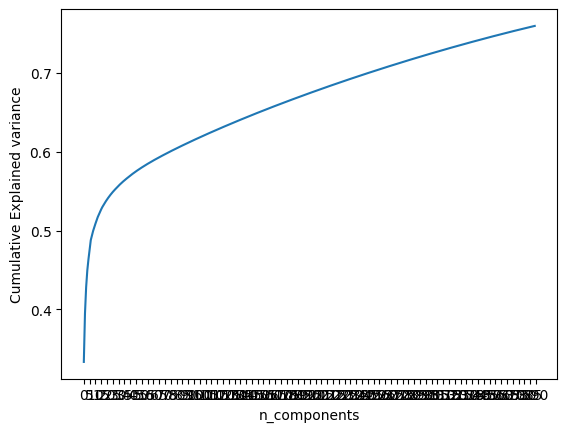

In [21]:
pca1.fit(x_train)
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.xlabel('n_components')
plt.xticks(np.arange(0,395,step=5))
plt.ylabel('Cumulative Explained variance')
plt.show()

bad cumulative explained variance ratio (<0.8), akan dipakai metode dekomposisi selain PCA

In [22]:
from sklearn.decomposition import KernelPCA
from sklearn.metrics import mean_squared_error
kpca=KernelPCA(fit_inverse_transform=True,n_jobs=-1)

In [23]:
def my_scorer(estimator, X, y=None):
    X_reduced = estimator.transform(X)
    X_preimage = estimator.inverse_transform(X_reduced)
    return -1 * mean_squared_error(X, X_preimage)

In [24]:
param_grid=[{
    "n_components":np.arange(50,400,50),
    "kernel":["poly","rbf","sigmoid","linear"]
}]

In [25]:
from sklearn.model_selection import GridSearchCV
grid_search=GridSearchCV(kpca,param_grid=param_grid,cv=3,scoring=my_scorer)

In [ ]:
grid_search.fit(X)

In [ ]:
grid_search.best_params_

kernel: poly, n_components:350

In [26]:
kpca1=KernelPCA(n_components=350,kernel='poly',random_state=42,n_jobs=-1)

In [27]:
x_train_preprocessed=kpca1.fit_transform(x_train)
x_test_preprocessed=kpca1.transform(x_test)
x_valid_preprocessed=kpca1.transform(x_valid)
(x_train_preprocessed.shape,x_test_preprocessed.shape,x_valid_preprocessed.shape)

((3139, 350), (393, 350), (392, 350))

In [28]:
kpca1.eigenvalues_

array([4230208.5   ,  629479.4   ,  461598.88  ,  408921.88  ,
        257880.34  ,  183549.81  ,  163364.78  ,  144944.84  ,
        106530.15  ,   99171.375 ,   75428.016 ,   68438.78  ,
         66333.91  ,   62898.727 ,   55637.695 ,   51893.414 ,
         49004.836 ,   44495.523 ,   43667.453 ,   38125.742 ,
         37047.875 ,   34912.445 ,   33791.71  ,   33413.758 ,
         31298.242 ,   29655.371 ,   28771.176 ,   27660.262 ,
         27097.895 ,   26407.79  ,   25199.55  ,   24890.303 ,
         24230.75  ,   23999.61  ,   22398.77  ,   22285.406 ,
         21691.52  ,   21530.61  ,   20499.875 ,   19893.266 ,
         19470.246 ,   19218.645 ,   18681.715 ,   18320.625 ,
         18197.312 ,   17864.977 ,   17782.031 ,   17164.918 ,
         16662.828 ,   16548.36  ,   16167.366 ,   16003.687 ,
         15821.208 ,   15734.392 ,   15424.177 ,   15308.054 ,
         14938.669 ,   14847.43  ,   14532.237 ,   14406.714 ,
         14310.497 ,   14275.661 ,   13882.5   ,   1380

In [29]:
x_train_preprocessed=pd.DataFrame(x_train_preprocessed,columns=kpca1.get_feature_names_out())
x_test_preprocessed=pd.DataFrame(x_test_preprocessed,columns=kpca1.get_feature_names_out())
x_valid_preprocessed=pd.DataFrame(x_valid_preprocessed,columns=kpca1.get_feature_names_out())
display(x_train_preprocessed.head())
display(x_valid_preprocessed.head())
display(x_test_preprocessed.head())

,kernelpca0,kernelpca1,kernelpca2,kernelpca3,kernelpca4,kernelpca5,kernelpca6,kernelpca7,kernelpca8,kernelpca9,...,kernelpca340,kernelpca341,kernelpca342,kernelpca343,kernelpca344,kernelpca345,kernelpca346,kernelpca347,kernelpca348,kernelpca349
0,42.401283,-3.863430,5.308450,-6.551887,4.971595,-1.802295,0.592129,-1.442455,-3.010965,-5.421664,...,-1.078929,-0.109366,-1.513703,1.097222,1.467511,-1.027194,-2.074240,0.214173,0.011948,-0.669932
1,-7.499546,-18.021839,-2.154493,-5.110653,-0.552102,-6.375772,1.307718,-1.936926,-0.129993,-1.168254,...,0.358791,0.696303,0.827198,-0.162122,-0.150330,-0.283061,-0.177665,-0.015968,-0.885248,-0.196571
2,-31.068762,1.569844,-1.004808,-0.125133,-5.754837,-1.575765,0.678419,7.807418,4.478329,0.274906,...,0.065195,-1.260123,-0.007045,-2.851095,-2.559597,-0.410332,-2.080716,-0.309855,-0.093749,-0.634238
3,26.302734,-5.503015,1.388447,-14.754540,4.270585,-2.677001,-2.493824,-2.069506,-0.576315,-2.649745,...,-2.237846,1.239820,-1.059124,-0.400397,1.641534,-2.126023,-1.740663,-1.895073,-0.771217,-0.584769
4,44.903923,1.146976,-4.262764,-4.359008,-15.844515,1.347975,0.050167,-6.655113,3.214459,1.291460,...,0.348234,-1.711803,-0.459892,1.336520,-0.244727,-0.021294,1.484490,1.894881,3.626866,-1.385742


,kernelpca0,kernelpca1,kernelpca2,kernelpca3,kernelpca4,kernelpca5,kernelpca6,kernelpca7,kernelpca8,kernelpca9,...,kernelpca340,kernelpca341,kernelpca342,kernelpca343,kernelpca344,kernelpca345,kernelpca346,kernelpca347,kernelpca348,kernelpca349
0,-48.121170,8.042245,11.429279,12.496186,-7.575027,-15.533486,-1.191125,12.124762,6.333716,-8.212995,...,-2.012743,1.274868,-0.165251,1.707054,0.908948,-2.658076,0.781021,0.119553,0.382273,0.026989
1,-43.520275,8.809931,8.286838,5.461800,-5.379681,-6.167666,0.473431,-1.128962,3.967704,-5.204691,...,-1.474573,-0.150166,-0.461319,-1.473948,-0.668841,0.379572,-1.301294,0.362293,0.181731,-0.187596
2,45.479424,-4.022581,12.043211,-13.716078,-15.041087,10.792287,2.002561,-5.347472,1.835440,-8.371447,...,-0.066591,-0.528038,-0.666136,-0.541582,0.745541,0.478935,0.253024,-1.146877,-0.342445,-0.671196
3,-22.122961,-36.529160,9.453444,17.157488,10.393755,8.024396,-3.552248,-9.888268,1.701646,1.689464,...,0.153961,0.052192,0.033028,0.072617,0.278618,0.014841,-0.174407,0.050217,0.092027,-0.007923
4,-9.453460,0.535361,-0.986079,-13.487976,2.429935,8.782606,-5.140003,3.593090,-0.725395,9.448922,...,0.419068,-1.148407,0.666052,-2.222310,0.089425,-0.064047,-0.517713,-0.711141,-0.735999,1.464909


,kernelpca0,kernelpca1,kernelpca2,kernelpca3,kernelpca4,kernelpca5,kernelpca6,kernelpca7,kernelpca8,kernelpca9,...,kernelpca340,kernelpca341,kernelpca342,kernelpca343,kernelpca344,kernelpca345,kernelpca346,kernelpca347,kernelpca348,kernelpca349
0,-37.901131,12.048519,-1.033023,2.401674,1.253743,-2.230760,2.447974,-3.034035,-1.452816,-8.466377,...,-0.054193,-0.457786,-1.284173,0.509919,0.966470,-0.562465,-0.924278,-0.047779,0.579878,0.537175
1,66.211227,12.366791,-1.793386,15.073751,4.501832,-5.317530,0.925566,3.769171,-2.117832,5.704792,...,-0.728917,-0.080247,-0.747185,-0.115494,0.949489,0.436334,-0.052370,0.626442,0.896064,1.405062
2,-40.315800,6.108852,5.959281,3.784726,-1.850853,-6.258838,-5.048437,3.113953,3.136251,-0.269171,...,-0.547807,0.812261,-0.577103,-0.773525,1.172182,1.568508,-0.633855,-0.251081,-0.210533,1.876749
3,-32.705395,-11.447750,5.591246,7.013695,-1.936679,-12.620559,-0.285052,15.030650,4.612330,-0.334610,...,-1.484763,0.204089,-0.296218,0.002044,-0.098830,-1.893255,-0.056484,-0.744860,0.411281,-0.052106
4,-10.386238,6.862007,-25.497955,8.128162,-2.769350,10.019218,-3.606369,-3.695427,4.537283,-7.154947,...,0.059273,-0.693704,0.146064,-0.298900,1.588293,-0.666441,-0.021384,-1.790125,1.681892,0.298708


In [30]:
from sklearn.preprocessing import LabelBinarizer
LB=LabelBinarizer()

In [31]:
y_train=LB.fit_transform(y_train)
y_train.shape

(3139, 3)

In [32]:
y_test=LB.fit_transform(y_test)
y_valid=LB.fit_transform(y_valid)
(y_test.shape,y_valid.shape)

((393, 3), (392, 3))

In [33]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_jobs=-1,random_state=42)

In [ ]:
param_grid_rfc=[{
    'n_estimators':[100,300,500,700],
    'max_depth':[5,10,20],
    'max_leaf_nodes':[5,10,20]
}]

In [ ]:
grid_search_rfc=GridSearchCV(rfc,param_grid_rfc,scoring='f1_macro',n_jobs=-1,cv=None)

In [ ]:
grid_search_rfc.fit(x_train_preprocessed,y_train)

In [ ]:
grid_search_rfc.best_params_

max_depth=20, max_leaf_nodes=20, n_estimators=500

In [34]:
rfc1=RandomForestClassifier(n_estimators=500,max_depth=20,max_leaf_nodes=20,n_jobs=-1,random_state=42)

In [35]:
rfc1.fit(x_train_preprocessed,y_train)

RandomForestClassifier(max_depth=20, max_leaf_nodes=20, n_estimators=500,
                       n_jobs=-1, random_state=42)

In [36]:
y_pred_val=rfc1.predict(x_valid_preprocessed)
y_pred_val.shape

(392, 3)

In [37]:
y_pred_test=rfc1.predict(x_test_preprocessed)
y_pred_test.shape

(393, 3)

In [38]:
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay,classification_report

In [39]:
LB.classes_

array(['Lung cancer, post-operation', 'Lung cancer, pre-operation',
       'Non-cancer control'], dtype='<U27')


Classification report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.94      0.94      0.94       167
           2       0.96      0.95      0.95       210

   micro avg       0.95      0.94      0.95       393
   macro avg       0.97      0.94      0.95       393
weighted avg       0.95      0.94      0.95       393
 samples avg       0.94      0.94      0.94       393



Text(0.5, 1.0, 'Non-cancer control')

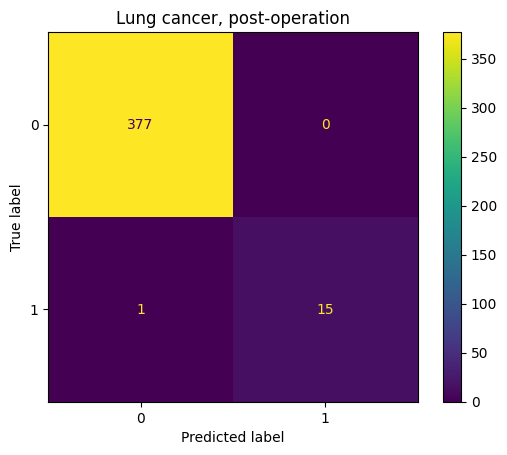

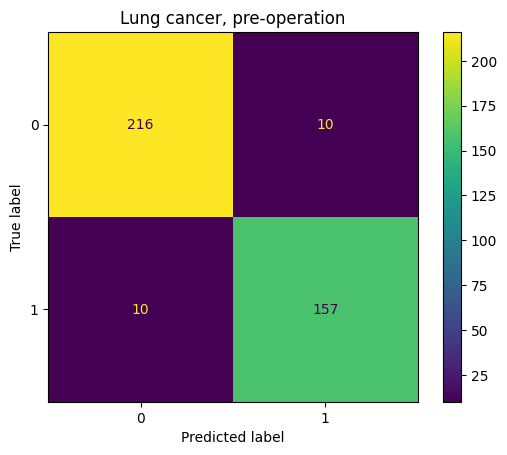

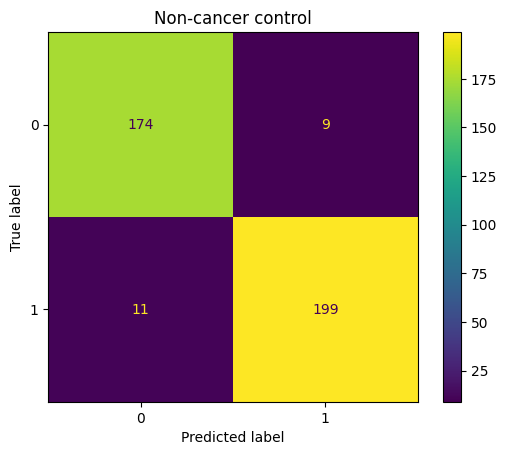

In [40]:
cm_test=multilabel_confusion_matrix(y_test,y_pred_test)
t1=ConfusionMatrixDisplay(cm_test[0])
t2=ConfusionMatrixDisplay(cm_test[1])
t3=ConfusionMatrixDisplay(cm_test[2])
print("\nClassification report")
print(classification_report(y_test, y_pred_test))
t1.plot()
t1.ax_.set_title('Lung cancer, post-operation')
t2.plot()
t2.ax_.set_title('Lung cancer, pre-operation')
t3.plot()
t3.ax_.set_title('Non-cancer control')


Classification report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       0.95      0.95      0.95       148
           2       0.96      0.97      0.97       222

   micro avg       0.96      0.96      0.96       392
   macro avg       0.97      0.94      0.96       392
weighted avg       0.96      0.96      0.96       392
 samples avg       0.96      0.96      0.96       392



Text(0.5, 1.0, 'Non-cancer control')

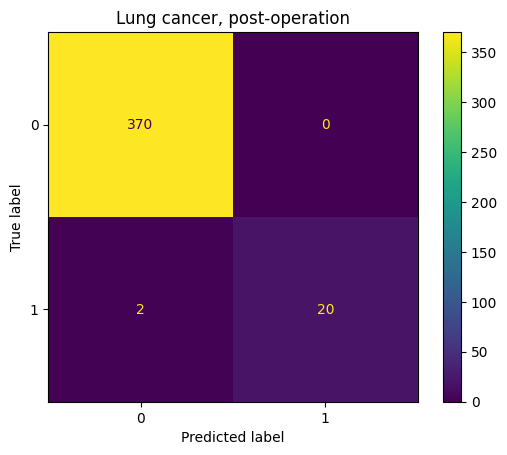

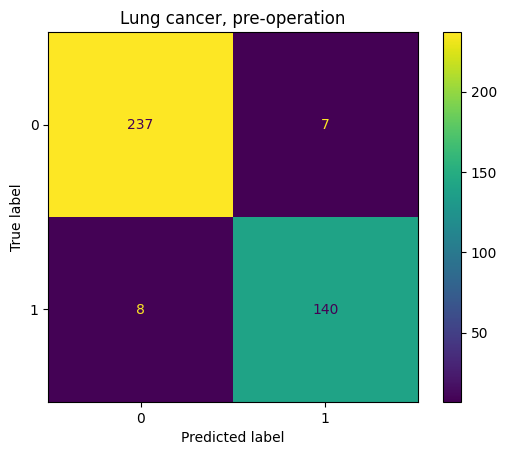

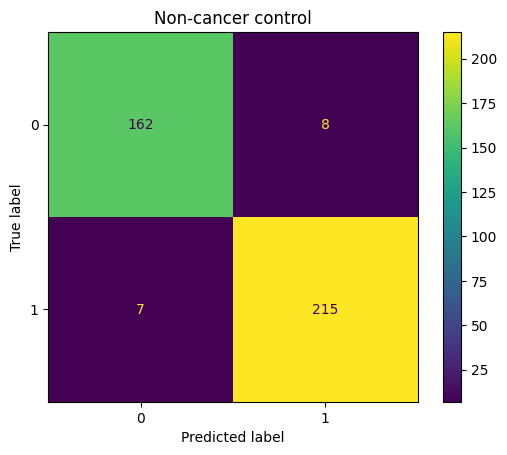

In [41]:
cm_valid=multilabel_confusion_matrix(y_valid,y_pred_val)
t1=ConfusionMatrixDisplay(cm_valid[0])
t2=ConfusionMatrixDisplay(cm_valid[1])
t3=ConfusionMatrixDisplay(cm_valid[2])
print("\nClassification report")
print(classification_report(y_valid, y_pred_val))
t1.plot()
t1.ax_.set_title('Lung cancer, post-operation')
t2.plot()
t2.ax_.set_title('Lung cancer, pre-operation')
t3.plot()
t3.ax_.set_title('Non-cancer control')

In [42]:
from sklearn.metrics import f1_score, accuracy_score
(f1_score(y_test,y_pred_test,average='macro'),accuracy_score(y_test,y_pred_test))

(0.9533382686702533, 0.9440203562340967)

In [43]:
(f1_score(y_valid,y_pred_val,average='macro'),accuracy_score(y_valid,y_pred_val))

(0.9559418765284314, 0.9566326530612245)

In [44]:
from lightgbm import LGBMClassifier
lgb=LGBMClassifier(random_state=42,n_jobs=-1)

In [ ]:
param_grid_lgb=[{
    'n_estimators':[100,300,500],
    'max_depth':[5,10,20],
    'num_leaves':[25,50],
    'learning_rate':[1e-1,1e-2],
    'boosting_type':['gbdt','dart']
}]

In [ ]:
grid_search_lgb=GridSearchCV(lgb,param_grid_lgb,scoring='f1_macro',n_jobs=-1,cv=None)

In [ ]:
grid_search_lgb.fit(x_train_preprocessed,LB.inverse_transform(y_train))

In [ ]:
grid_search_lgb.best_params_

'boosting_type': 'gbdt',
'learning_rate': 0.1,
'max_depth': 20,
'n_estimators': 500,
'num_leaves': 25

In [45]:
lgb1=LGBMClassifier('gbdt',learning_rate=1e-1,max_depth=20,n_estimators=500,num_leaves=25)

In [46]:
lgb1.fit(x_train_preprocessed,LB.inverse_transform(y_train))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89250
[LightGBM] [Info] Number of data points in the train set: 3139, number of used features: 350
[LightGBM] [Info] Start training from score -3.095832
[LightGBM] [Info] Start training from score -0.919961
[LightGBM] [Info] Start training from score -0.586577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

LGBMClassifier(max_depth=20, n_estimators=500, num_leaves=25)

In [47]:
y_pred_val=lgb1.predict(x_valid_preprocessed)
y_pred_val=LB.transform(y_pred_val)
y_pred_val.shape

(392, 3)

In [48]:
y_pred_test=lgb1.predict(x_test_preprocessed)
y_pred_test=LB.transform(y_pred_test)
y_pred_test.shape

(393, 3)


Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.96      0.99      0.98       167
           2       0.99      0.97      0.98       210

   micro avg       0.98      0.98      0.98       393
   macro avg       0.99      0.99      0.99       393
weighted avg       0.98      0.98      0.98       393
 samples avg       0.98      0.98      0.98       393



Text(0.5, 1.0, 'Non-cancer control')

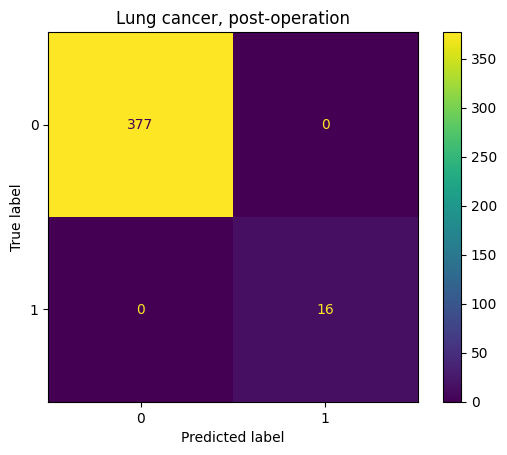

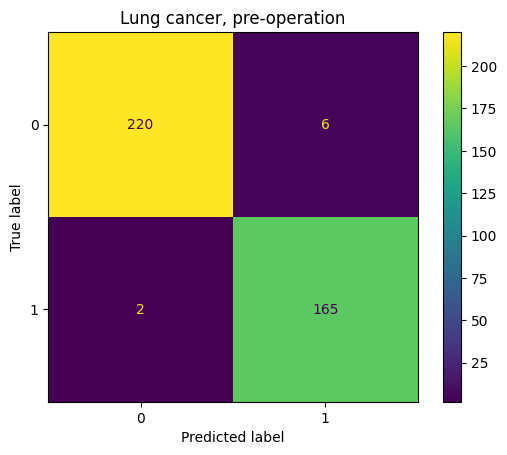

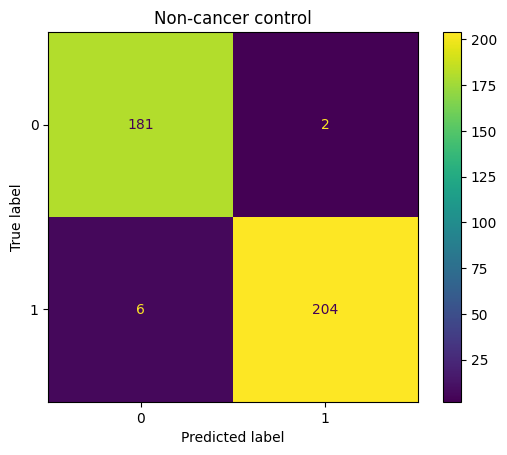

In [49]:
cm_test=multilabel_confusion_matrix(y_test,y_pred_test)
t1=ConfusionMatrixDisplay(cm_test[0])
t2=ConfusionMatrixDisplay(cm_test[1])
t3=ConfusionMatrixDisplay(cm_test[2])
print("\nClassification report")
print(classification_report(y_test, y_pred_test))
t1.plot()
t1.ax_.set_title('Lung cancer, post-operation')
t2.plot()
t2.ax_.set_title('Lung cancer, pre-operation')
t3.plot()
t3.ax_.set_title('Non-cancer control')


Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.97      0.99      0.98       148
           2       1.00      0.98      0.99       222

   micro avg       0.98      0.98      0.98       392
   macro avg       0.99      0.99      0.99       392
weighted avg       0.98      0.98      0.98       392
 samples avg       0.98      0.98      0.98       392



Text(0.5, 1.0, 'Non-cancer control')

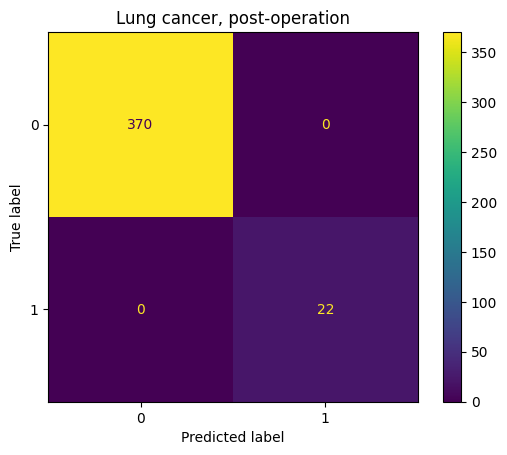

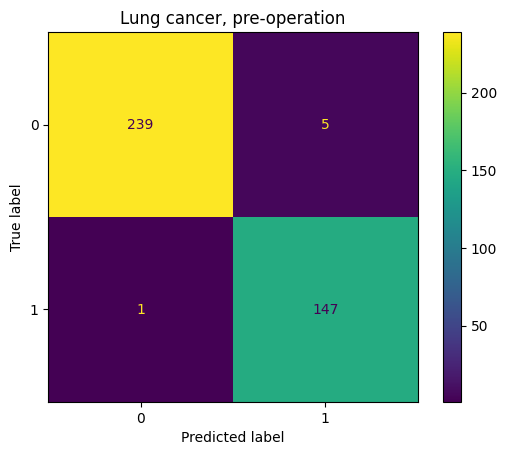

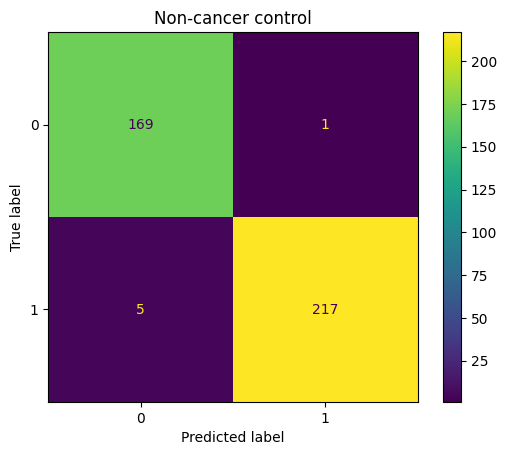

In [50]:
cm_valid=multilabel_confusion_matrix(y_valid,y_pred_val)
t1=ConfusionMatrixDisplay(cm_valid[0])
t2=ConfusionMatrixDisplay(cm_valid[1])
t3=ConfusionMatrixDisplay(cm_valid[2])
print("\nClassification report")
print(classification_report(y_valid, y_pred_val))
t1.plot()
t1.ax_.set_title('Lung cancer, post-operation')
t2.plot()
t2.ax_.set_title('Lung cancer, pre-operation')
t3.plot()
t3.ax_.set_title('Non-cancer control')

In [51]:
from sklearn.metrics import f1_score, accuracy_score
(f1_score(y_test,y_pred_test,average='macro'),accuracy_score(y_test,y_pred_test))

(0.9857001972386588, 0.9796437659033079)

In [52]:
(f1_score(y_valid,y_pred_val,average='macro'),accuracy_score(y_valid,y_pred_val))

(0.9887878787878788, 0.9846938775510204)

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler((-1,1))

In [54]:
x_train_scaled=scaler.fit_transform(x_train_preprocessed)
x_valid_scaled=scaler.transform(x_valid_preprocessed)
x_test_scaled=scaler.transform(x_test_preprocessed)

Sebelum pake SVM harus di scale dulu, karena SVM distance-based algorithm, buat minimalisir bias

In [55]:
from sklearn.svm import SVC
svc=SVC(random_state=42)

In [56]:
param_grid_svc=[{
    'C':[0.1,0.2,0.4,0.6,0.8,1,5,10],
    'kernel':['poly','rbf','sigmoid'],
    'degree':[3,5],
    'gamma':['scale','auto']
}]

In [57]:
grid_search_svc=GridSearchCV(svc,param_grid_svc,scoring='f1_macro',n_jobs=-1,cv=None)

In [58]:
grid_search_svc.fit(x_train_scaled,LB.inverse_transform(y_train))

GridSearchCV(estimator=SVC(random_state=42), n_jobs=-1,
             param_grid=[{'C': [0.1, 0.2, 0.4, 0.6, 0.8, 1, 5, 10],
                          'degree': [3, 5], 'gamma': ['scale', 'auto'],
                          'kernel': ['poly', 'rbf', 'sigmoid']}],
             scoring='f1_macro')

In [59]:
grid_search_svc.best_params_

{'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}

'C': 1, 'degree': 3, 'kernel': 'poly', 'gamma':'scale'

In [60]:
svc1=SVC(C=1,degree=3,kernel='poly',random_state=42,gamma='scale')

In [61]:
svc1.fit(x_train_scaled,LB.inverse_transform(y_train))

SVC(C=1, kernel='poly', random_state=42)

In [62]:
y_pred_val=svc1.predict(x_valid_preprocessed)
y_pred_val=LB.transform(y_pred_val)
y_pred_val.shape

(392, 3)

In [63]:
y_pred_test=svc1.predict(x_test_preprocessed)
y_pred_test=LB.transform(y_pred_test)
y_pred_test.shape

(393, 3)


Classification report
              precision    recall  f1-score   support

           0       0.47      1.00      0.64        16
           1       0.90      0.97      0.93       167
           2       0.99      0.85      0.92       210

   micro avg       0.91      0.91      0.91       393
   macro avg       0.79      0.94      0.83       393
weighted avg       0.93      0.91      0.91       393
 samples avg       0.91      0.91      0.91       393



Text(0.5, 1.0, 'Non-cancer control')

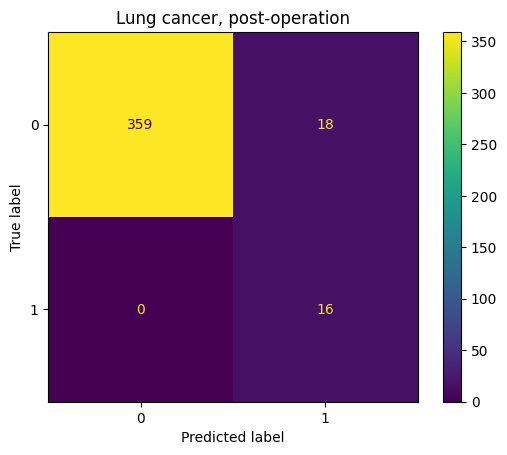

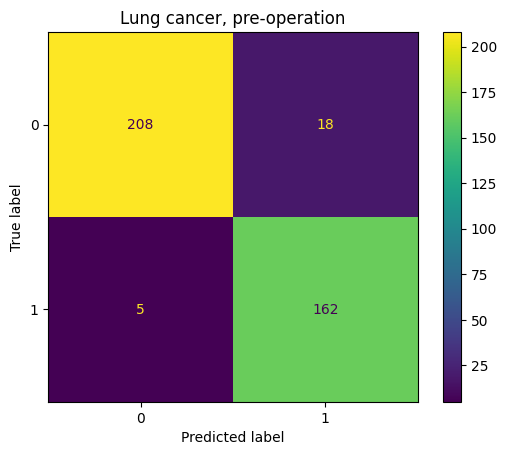

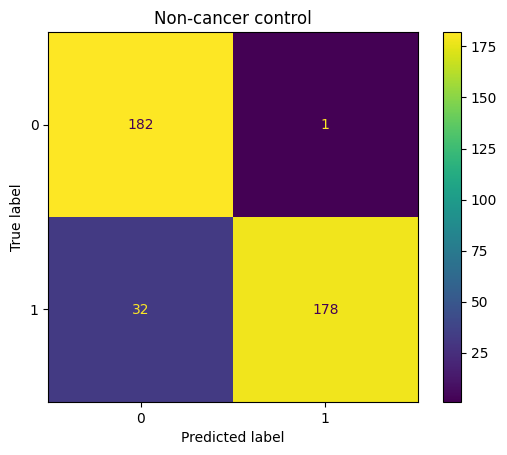

In [64]:
cm_test=multilabel_confusion_matrix(y_test,y_pred_test)
t1=ConfusionMatrixDisplay(cm_test[0])
t2=ConfusionMatrixDisplay(cm_test[1])
t3=ConfusionMatrixDisplay(cm_test[2])
print("\nClassification report")
print(classification_report(y_test, y_pred_test))
t1.plot()
t1.ax_.set_title('Lung cancer, post-operation')
t2.plot()
t2.ax_.set_title('Lung cancer, pre-operation')
t3.plot()
t3.ax_.set_title('Non-cancer control')


Classification report
              precision    recall  f1-score   support

           0       0.42      1.00      0.59        22
           1       0.92      0.94      0.93       148
           2       1.00      0.85      0.92       222

   micro avg       0.89      0.89      0.89       392
   macro avg       0.78      0.93      0.81       392
weighted avg       0.94      0.89      0.90       392
 samples avg       0.89      0.89      0.89       392



Text(0.5, 1.0, 'Non-cancer control')

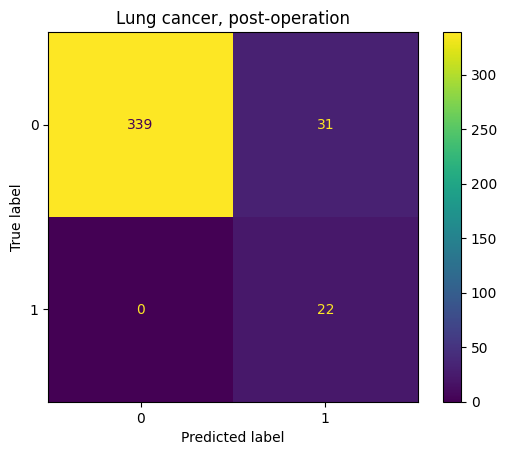

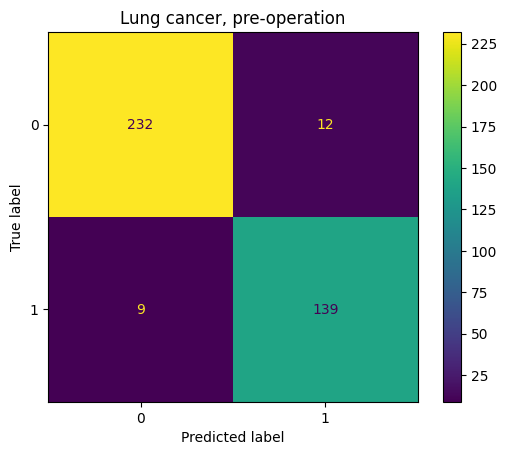

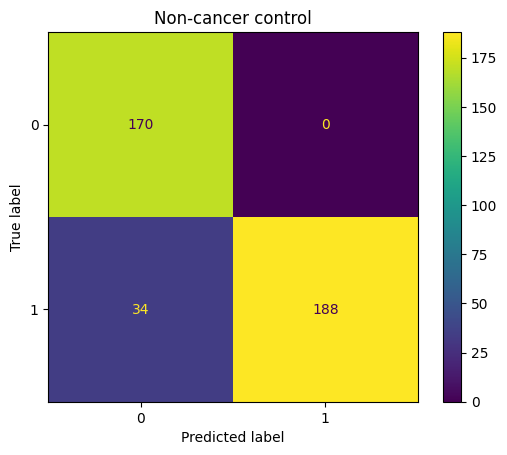

In [65]:
cm_valid=multilabel_confusion_matrix(y_valid,y_pred_val)
t1=ConfusionMatrixDisplay(cm_valid[0])
t2=ConfusionMatrixDisplay(cm_valid[1])
t3=ConfusionMatrixDisplay(cm_valid[2])
print("\nClassification report")
print(classification_report(y_valid, y_pred_val))
t1.plot()
t1.ax_.set_title('Lung cancer, post-operation')
t2.plot()
t2.ax_.set_title('Lung cancer, pre-operation')
t3.plot()
t3.ax_.set_title('Non-cancer control')

In [66]:
from sklearn.metrics import f1_score, accuracy_score
(f1_score(y_test,y_pred_test,average='macro'),accuracy_score(y_test,y_pred_test))

(0.8296282247888005, 0.905852417302799)

In [67]:
(f1_score(y_valid,y_pred_val,average='macro'),accuracy_score(y_valid,y_pred_val))

(0.8111685745619998, 0.8903061224489796)